# 3章: 組合せのあるテスト: 要素に分解して考える

必要なモジュールの読み込み

In [113]:
import os
import numpy as np
from matplotlib import pyplot as plt
from cmdstanpy import CmdStanModel
import arviz as az
from scipy import stats
from scipy.special import expit

az.style.use("arviz-darkgrid")
np.random.seed(0)

script_dir = os.path.dirname('chapter3.ipynb')

## チャーリーのレポート

クリック率 $\theta$ のサンプルの軌跡

19:00:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed


19:00:30 - cmdstanpy - INFO - CmdStan done processing.



Processing csv files: /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmps55d5hwa/modeltp0aa0sj/model-20230522190030_1.csv, /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmps55d5hwa/modeltp0aa0sj/model-20230522190030_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

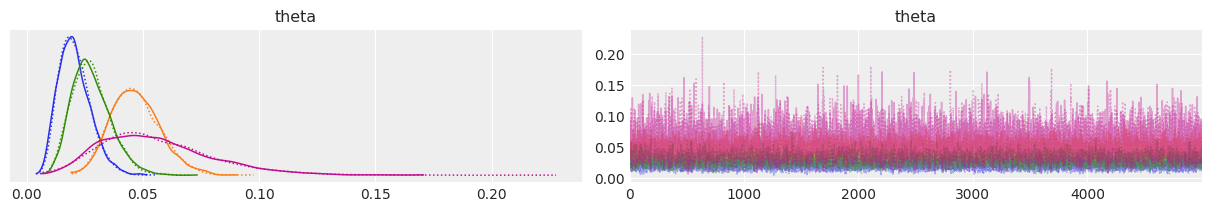

In [72]:
n = [434, 382, 394, 88]
clicks = [8, 17, 10, 4]

file_path = os.path.join(script_dir, 'model.stan')
model = CmdStanModel(stan_file=file_path)

data = {'N': len(n), 'n': n, 'clicks': clicks}

fit = model.sample(
  data=data,
  chains=2,
  seed=0,
  iter_warmup=1000,
  iter_sampling=5000,
  show_progress=True
)

cmdstanpy_data = az.from_cmdstanpy(
    posterior=fit,
    log_likelihood="lp__",
)

print(fit.diagnose())
az.plot_trace(cmdstanpy_data.posterior, compact=True) # 事後分布からのサンプルの可視化

In [73]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-188.103000,0.019714,1.432060,-190.935000,-187.764000,-186.433000,5276.69,34715.1,1.000140
theta[1],0.020656,0.000065,0.006854,0.010816,0.019934,0.033073,11260.60,74083.1,0.999977
theta[2],0.046815,0.000101,0.010598,0.030668,0.046163,0.065453,11014.90,72466.3,1.000030
theta[3],0.027782,0.000083,0.008353,0.015643,0.026943,0.042791,10184.70,67004.5,0.999848
theta[4],0.055617,0.000232,0.024142,0.022960,0.052064,0.100322,10866.00,71487.1,0.999879


確率変数 $\theta$ の事後分布の95% HDIの比較

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

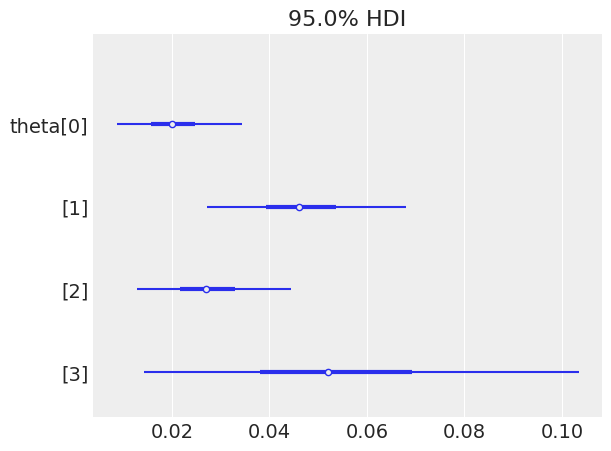

In [74]:
az.plot_forest(cmdstanpy_data.posterior, combined=True, hdi_prob=0.95)

A案とB案のクリック率の差が正となる割合

In [75]:
theta_samples = fit.stan_variable('theta')

print((theta_samples[:, 1] - theta_samples[:, 0] > 0).mean())

0.9857


A案とD案のクリック率の差が正となる割合

In [76]:
print((theta_samples[:, 3] - theta_samples[:, 0] > 0).mean())

0.9504


## 効果に着目したモデリング

ロジスティック関数

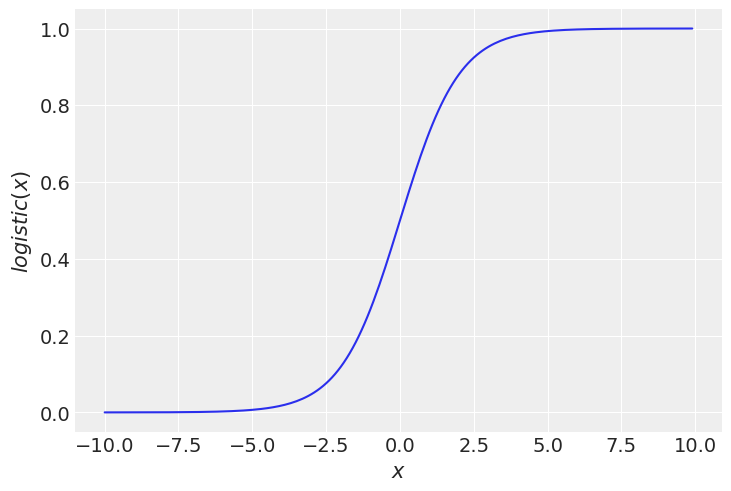

In [77]:
xs = np.arange(-10, 10, 0.1)
plt.plot(xs, 1 / (1 + np.exp(-xs)))
plt.xlabel(r'$x$')
plt.ylabel(r'$logistic(x)$')
plt.show()

さまざまな正規分布の例

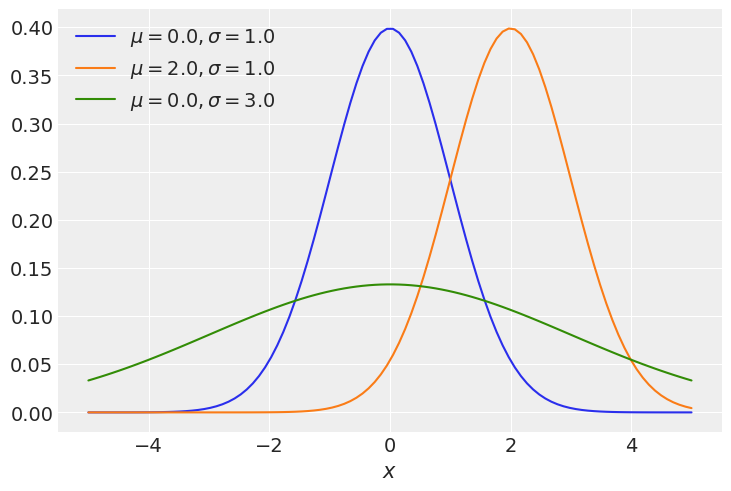

In [78]:
from scipy import stats
x = np.linspace(-5, 5, 100)
params = [(0, 1), (2, 1), (0, 3)]
for mu, sigma in params:
  plt.plot(x, stats.norm.pdf(x, mu, sigma),
      label=r'$\mu=%.1f, \sigma=%.1f$' % (mu, sigma))
plt.legend()
plt.xlabel(r'$x$')
plt.show()

## 統計モデルを書き直す

19:00:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       


19:00:32 - cmdstanpy - INFO - CmdStan done processing.



Processing csv files: /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmps55d5hwa/model_comb3h13j7va/model_comb-20230522190031_1.csv, /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmps55d5hwa/model_comb3h13j7va/model_comb-20230522190031_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

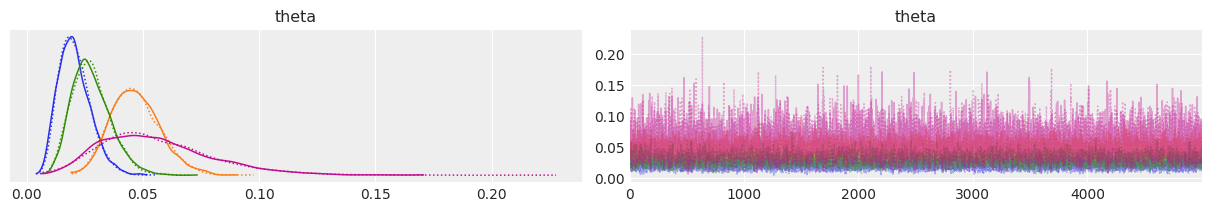

In [79]:
img = [0, 0, 1, 1]
btn = [0, 1, 0, 1]

file_path = os.path.join(script_dir, 'model_comb.stan')
model = CmdStanModel(stan_file=file_path)

data = {'N': len(n),'n': n, 'clicks': clicks , 'img': img, 'btn': btn}

fit = model.sample(
  data=data,
  chains=2,
  seed=0,
  iter_warmup=1000,
  iter_sampling=5000,
  show_progress=True
)

cmdstanpy_data_comb = az.from_cmdstanpy(
    posterior=fit,
    log_likelihood="log_lik",
)

print(fit.diagnose())
az.plot_trace(cmdstanpy_data.posterior, compact=True) # 事後分布からのサンプルの可視化

$\beta$ の事後分布の可視化

array([<Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>], dtype=object)

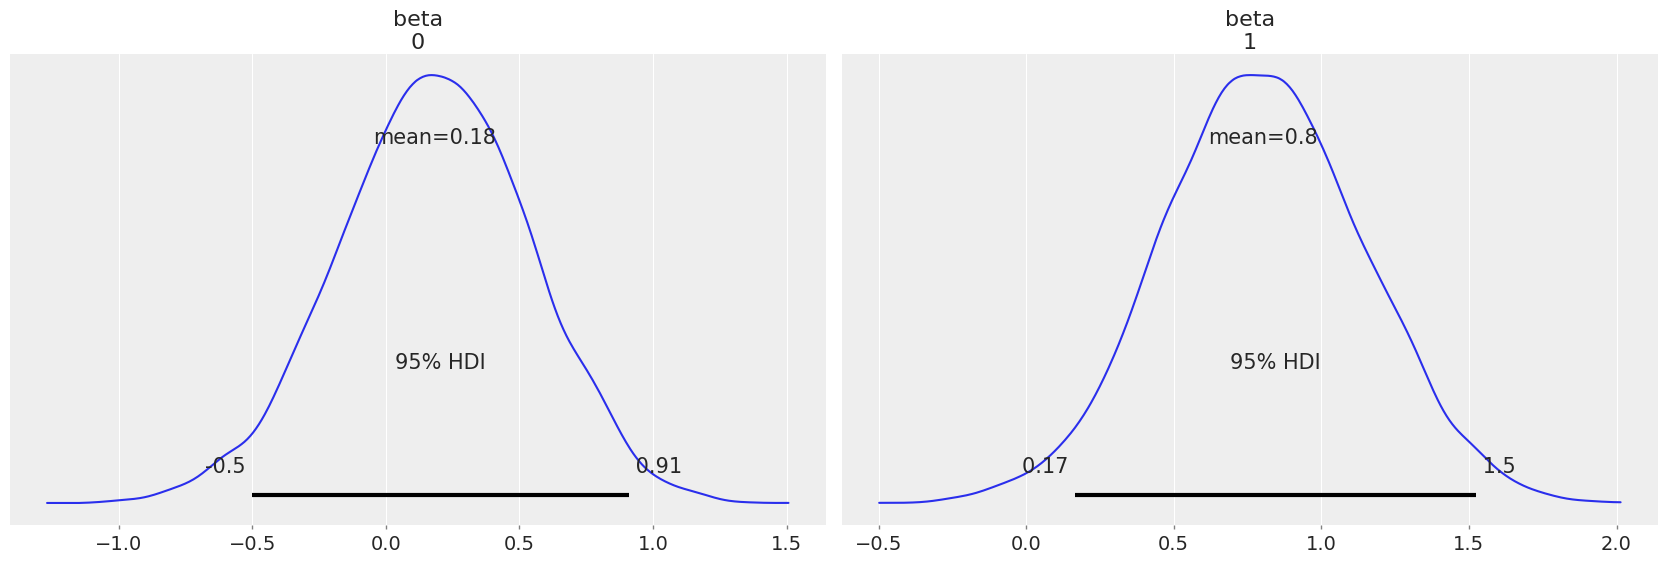

In [80]:
az.plot_posterior(cmdstanpy_data_comb.posterior.beta,hdi_prob=0.95) # 事後分布の可視化

In [81]:
beta_samples = fit.stan_variable('beta')

print((beta_samples[:, 1] > 0).mean())

0.989


   クリック率 $\theta$ がデザイン案ごとに独立したモデル（Individual）と、
   施策効果によって接続されたモデル（Combined）それぞれについて得られた事後分布の95% HDIの比較

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

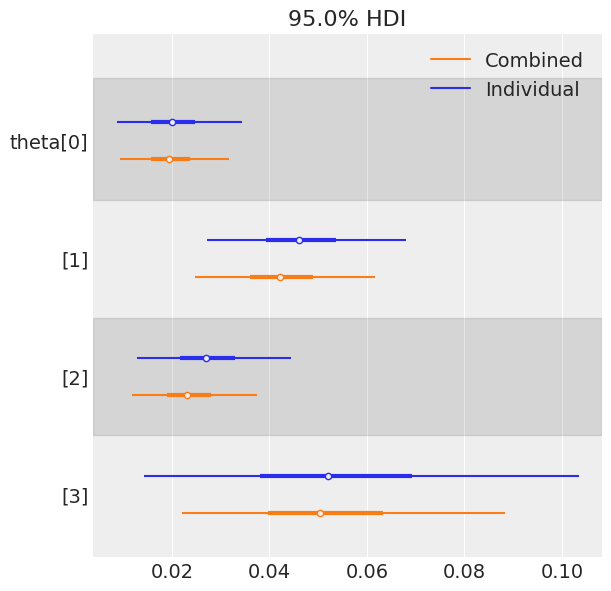

In [82]:
az.plot_forest([cmdstanpy_data.posterior.theta, cmdstanpy_data_comb.posterior.theta], combined=True, hdi_prob=0.95, model_names=['Individual', 'Combined'])

In [83]:
theta_samples = fit.stan_variable('theta')

print((theta_samples[:, 1] - theta_samples[:, 0] > 0).mean()) # 以前の値は0.9857
print((theta_samples[:, 3] - theta_samples[:, 0] > 0).mean()) # 以前の値は0.9504

0.989
0.9555


## 完成したレポート、間違ったモデル

完成したレポートに、同じ統計モデルをあてはめたときのサンプルの軌跡

19:28:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████      | 00:00 Iteration: 2200 / 6000 [ 36%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


19:28:46 - cmdstanpy - INFO - CmdStan done processing.



Processing csv files: /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmps55d5hwa/model_combwn_zeat_/model_comb-20230522192846_1.csv, /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmps55d5hwa/model_combwn_zeat_/model_comb-20230522192846_2.csv, /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmps55d5hwa/model_combwn_zeat_/model_comb-20230522192846_3.csv, /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmps55d5hwa/model_combwn_zeat_/model_comb-20230522192846_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

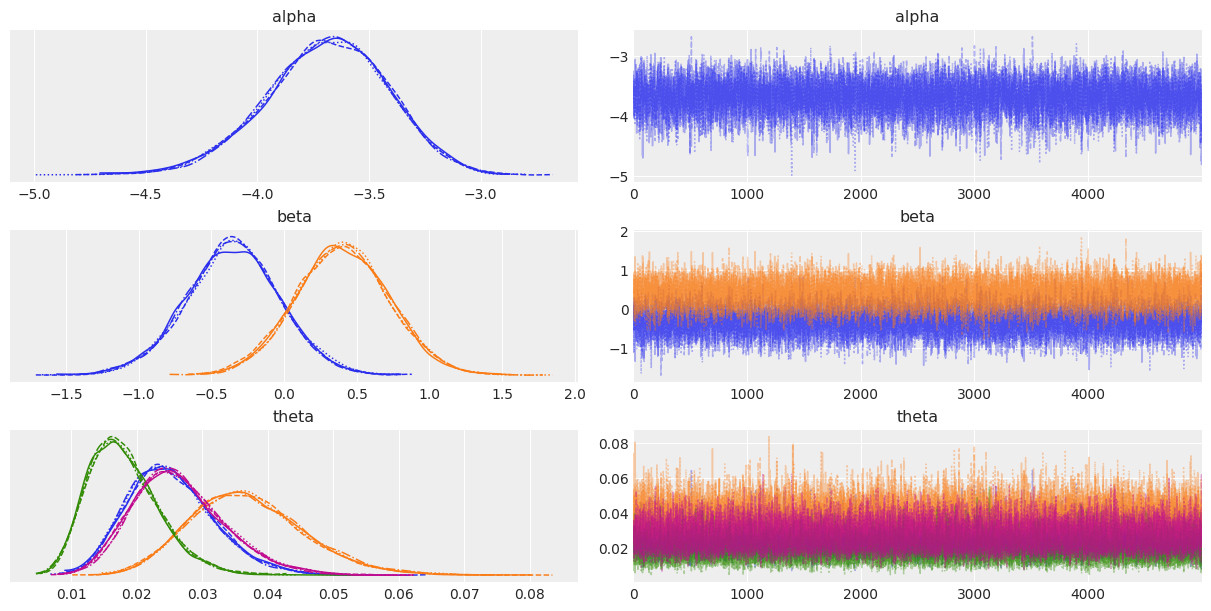

In [106]:
n = [434, 382, 394, 412]
clicks = [8, 17, 10, 8]
img = [0, 0, 1, 1]
btn = [0, 1, 0, 1]

file_path = os.path.join(script_dir, 'model_comb.stan')
model = CmdStanModel(stan_file=file_path)

data = {'N': len(n),'n': n, 'clicks': clicks , 'img': img, 'btn': btn}

fit_comb = model.sample(
  data=data,
  chains=4,
  seed=0,
  iter_warmup=1000,
  iter_sampling=5000,
  show_progress=True
)

cmdstanpy_data_comb = az.from_cmdstanpy(
    posterior=fit_comb,
    log_likelihood="log_lik",
)

print(fit_comb.diagnose())
az.plot_trace(cmdstanpy_data_comb.posterior, compact=True) # 事後分布からのサンプルの可視化

In [85]:
beta_samples = fit_comb.stan_variable('beta')

print((beta_samples[:, 1] > 0).mean())

0.89615


交互作用項を追加した統計モデルから得られたサンプルの軌跡

19:00:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▎     | 00:00 Iteration: 2400 / 6000 [ 40%]  (Sampling)


chain 1 |█████████▏| 00:00 Iteration: 5400 / 6000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


19:00:35 - cmdstanpy - INFO - CmdStan done processing.



Processing csv files: /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmps55d5hwa/model_intj3azvcts/model_int-20230522190034_1.csv, /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmps55d5hwa/model_intj3azvcts/model_int-20230522190034_2.csv, /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmps55d5hwa/model_intj3azvcts/model_int-20230522190034_3.csv, /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmps55d5hwa/model_intj3azvcts/model_int-20230522190034_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

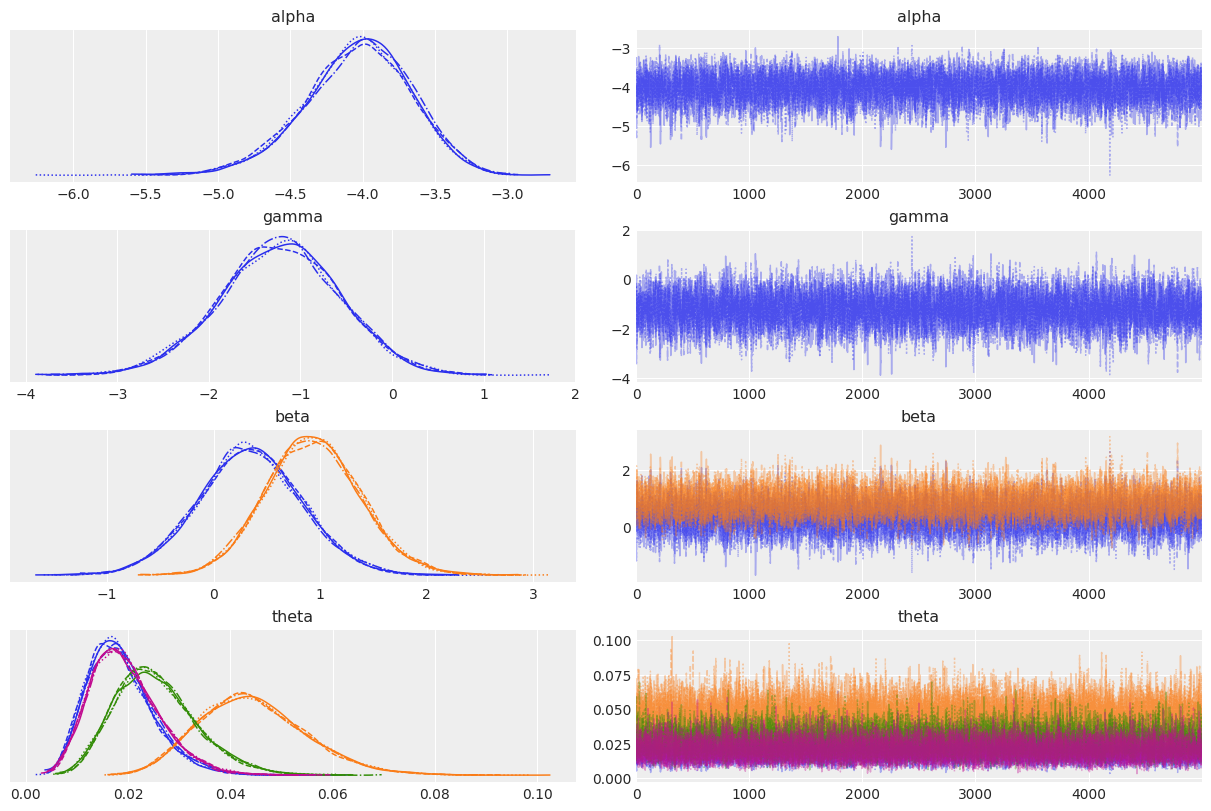

In [86]:
file_path = os.path.join(script_dir, 'model_int.stan')
model = CmdStanModel(stan_file=file_path)

data = {'N': len(n),'n': n, 'clicks': clicks , 'img': img, 'btn': btn}

fit = model.sample(
  data=data,
  chains=4,
  seed=0,
  iter_warmup=1000,
  iter_sampling=5000,
  show_progress=True
)

cmdstanpy_data_int = az.from_cmdstanpy(
    posterior=fit,
    log_likelihood="log_lik",
)

print(fit.diagnose())
az.plot_trace(cmdstanpy_data_int.posterior, compact=True) # 事後分布からのサンプルの可視化

In [87]:
gamma_samples = fit.stan_variable('gamma')

print((gamma_samples < 0).mean())

0.9689


In [88]:
beta_samples = fit.stan_variable('beta')

print((beta_samples[:, 0] > 0).mean())
print((beta_samples[:, 1] > 0).mean())

0.7623
0.98555


## モデル選択

主効果のみのモデルCombinedの可視化

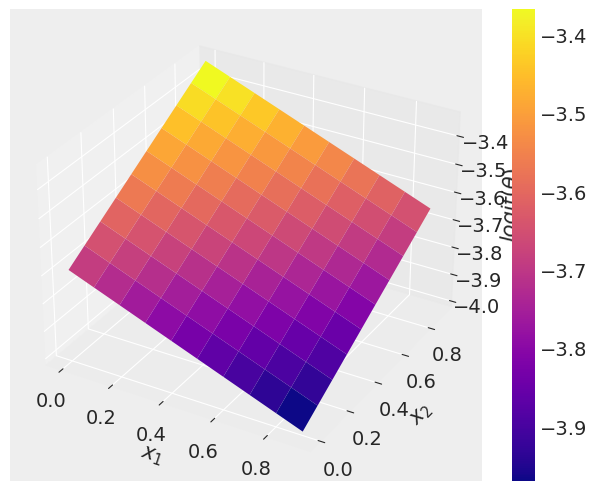

In [89]:
alpha_samples_comb = fit_comb.stan_variable('alpha')
beta_samples_comb = fit_comb.stan_variable('beta')
x1 = np.arange(0, 1, 0.1)
x2 = np.arange(0, 1, 0.1)
X1, X2 = np.meshgrid(x1, x2)
logit_theta = (alpha_samples_comb.mean() +
      beta_samples_comb[:, 0].mean() * X1 +
      beta_samples_comb[:, 1].mean() * X2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X1, X2, logit_theta, cmap='plasma')
fig.colorbar(surf)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$logit(\theta)$')

plt.show()

交互作用を含んだモデルInteractionの可視化

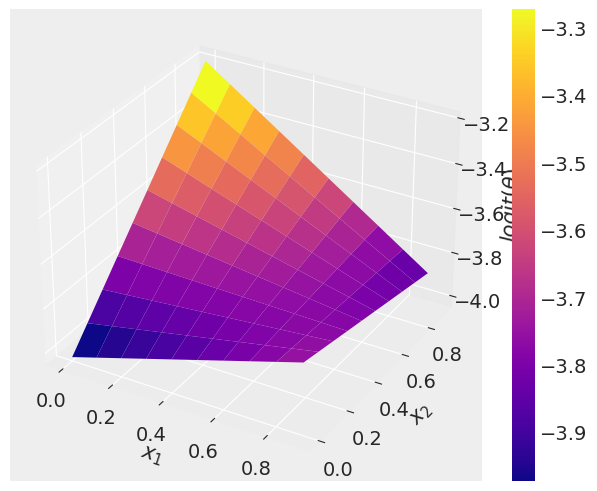

In [90]:
x1 = np.arange(0, 1, 0.1)
x2 = np.arange(0, 1, 0.1)
X1, X2 = np.meshgrid(x1, x2)
alpha_samples = fit.stan_variable('alpha')
beta_samples = fit.stan_variable('beta')
gamma_samples = fit.stan_variable('gamma')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Y = (alpha_samples.mean() +
      beta_samples[:, 0].mean() * X1 +
      beta_samples[:, 1].mean() * X2 +
      gamma_samples.mean() * X1 * X2)
surf = ax.plot_surface(X1, X2, Y, cmap='plasma')
fig.colorbar(surf)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$logit(\theta)$')
plt.show()

In [91]:
#　モデルの推定結果は書籍と同じだが，WAICの値が異なる

waic_comb = az.waic(cmdstanpy_data_comb)
waic_int = az.waic(cmdstanpy_data_int)

az.compare({'int': cmdstanpy_data_int, 'comb': cmdstanpy_data_comb}, ic='waic')

/Users/tueno/.pyenv/versions/3.11.0/envs/bayesian-modeling/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/tueno/.pyenv/versions/3.11.0/envs/bayesian-modeling/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/tueno/.pyenv/versions/3.11.0/envs/bayesian-modeling/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warn

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
int,0,-11.770713,2.067489,0.000000,1.0,0.264642,0.000000,True,log
comb,1,-14.204092,3.783158,2.433379,0.0,0.561111,0.371827,True,log


# （付録）p_waicを計算する

WAICの定義は，
$$\text{WAIC} = -2(\text{lpd} - p_{\text{WAIC}})$$
ここで，

$$\text{lpd}= \sum_{i=1}^{N}\text{log Pr}(y_i) \\
  p_{\text{WAIC}}= \sum_{i=1}^{N}\text{V}(y_i)$$
である

$p_{\text{WAIC}}$を計算し結果が一致するか確認する

In [96]:
# まずは事後分布からのサンプルを取得する
alpha_samples_comb = fit_comb.stan_variable('alpha')
beta_samples_comb = fit_comb.stan_variable('beta')

# imgとbtnをNumPy配列に変換する
img = np.array(img) # 画像の有無
btn = np.array(btn) # ボタンの有無

# サンプルのそれぞれをパラメータとして与えたときの各y_iの対数尤度を計算する
log_lik_comb = np.zeros((len(alpha_samples_comb), len(n))) # 各y_iの対数尤度を格納する配列，サイズは(サンプル数, データ数)
for i in range(len(alpha_samples_comb)): # サンプルの数だけループ
    logit_theta = alpha_samples_comb[i] + beta_samples_comb[i, 0] * img + beta_samples_comb[i, 1] * btn # ロジット逆変換したパラメータを計算
    log_lik_comb[i] = stats.binom.logpmf(clicks, n, expit(logit_theta)) # 各y_iの対数尤度を計算し，配列に格納
    # stats.binom.logpmfは二項分布の対数尤度を計算する関数
    # expitはロジット逆変換を行う関数で，ロジットを確率に変換している

# 各y_iの対数尤度の平均をとる
log_lik_comb_mean = log_lik_comb.mean(axis=0) # axis=0で各列の平均をとる

# 各y_iの対数尤度の和をとる
lpd_comb = log_lik_comb_mean.sum()

# 各y_iの対数尤度の分散を計算し、和をとる
lpd_var_comb = log_lik_comb.var(axis=0).sum() # axis=0で各列の分散をとる

# WAICの計算
waic_comb = -2 * (lpd_comb - lpd_var_comb)

print(lpd_var_comb)  # model_comb.stanの場合のlpdの分散の和を出力


3.7831571331945764


In [98]:
# まずは事後分布からのサンプルを取得する
alpha_samples_int = fit.stan_variable('alpha')
beta_samples_int = fit.stan_variable('beta')
gamma_samples = fit.stan_variable('gamma')

# imgとbtnをNumPy配列に変換する
img = np.array(img)
btn = np.array(btn)

# サンプルのそれぞれをパラメータとして与えたときの各y_iの対数尤度を計算する
log_lik_int = np.zeros((len(alpha_samples_int), len(n)))
for i in range(len(alpha_samples_int)):
    logit_theta = alpha_samples_int[i] + beta_samples_int[i, 0] * img + beta_samples_int[i, 1] * btn + gamma_samples[i] * img * btn # ロジット逆変換したパラメータを計算
    log_lik_int[i] = stats.binom.logpmf(clicks, n, expit(logit_theta)) # 各y_iの対数尤度を計算し，配列に格納
    # stats.binom.logpmfは二項分布の対数尤度を計算する関数
    # expitはロジット逆変換を行う関数で，ロジットを確率に変換している

# 各y_iの対数尤度の平均をとる
log_lik_int_mean = log_lik_int.mean(axis=0)

# 各y_iの対数尤度の和をとる
lpd_int = log_lik_int_mean.sum()

# 各y_iの対数尤度の分散を計算し、和をとる
lpd_var_int = log_lik_int.var(axis=0).sum()

# WAICの計算
waic_int = -2 * (lpd_int - lpd_var_int)

print(lpd_var_int)  # model_int.stanの場合のlpdの分散の和を出力


2.067489712462744


参考：
- Statistical Rethinking Chapter 6
- [Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC](https://arxiv.org/abs/1507.04544)
- [WAICを計算してみる - 統計コンサルの議事メモ](https://ushi-goroshi.hatenablog.com/entry/2017/12/24/225748)